In [2]:
import time
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelBinarizer

In [4]:
shift = 4320

In [5]:
prefix = 'C:\\Users\\rafae\\Desktop\\Coleta\\features\\features_hog_*.csv'

In [6]:
files_list = glob.glob(prefix)
print(len(files_list))

513


In [7]:
# read features
frames = [pd.read_csv(f, header=0) for f in files_list ]
len(frames)

513

In [8]:
ds = pd.concat(frames)

In [9]:
ds.shape

(7680, 17282)

In [10]:
ds.head()

,0,1,2,3,4,5,6,7,8,9,...,17272,17273,17274,17275,17276,17277,17278,17279,17280,17281
0,1,p002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.071793,0.090339,0.127822,0.127822,0.042653,0.053141,0.059538,0.003019,0.019839,0.127822
1,1,p002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.069514,0.119957,0.119957,0.119957,0.024254,0.051084,0.053452,0.014108,0.010533,0.119957
2,1,p002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.103166,0.037546,0.044686,0.122575,0.033838,0.104095,0.087389,0.003405,0.009884,0.017647
3,1,p002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.132490,0.091092,0.132490,0.123109,0.038147,0.132490,0.132490,0.050142,0.042432,0.028560
4,1,p002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.052366,0.038015,0.034714,0.061695,0.040908,0.070168,0.032586,0.004734,0.009425,0.023819


In [11]:
# convert points do binary Eyes ON or OFF Road
on_road_points = [13, 14, 16, 17]
on_off_road_bit = np.where(ds['0'].isin(on_road_points), 1,0)
print(ds['0'].isin(on_road_points).value_counts())

False    6105
True     1575
Name: 0, dtype: int64


In [13]:
#yData = on_off_road_bit
yData = None
# IR1
#yData = ds['0']

#IR1 + IR2
yData =  np.concatenate((on_off_road_bit,on_off_road_bit), axis=0)

groups_data =  pd.concat([ds['1'],ds['1']], axis=0)

In [14]:
#xData = ds.iloc[:,2+shift:2+shift+shift]
#xData = pd.concat([ds.iloc[:,2+shift:2+shift+shift], ds_lbp.iloc[:,2:2+shift_lbp]], axis=1)

xData = None

#IR1 + IR2
ir1 = ds.iloc[:,2+shift:2+shift+shift]
ir2 = ds.iloc[:,2+shift+shift:2+shift+shift+shift]
print(ir1.shape, ir2.shape, type(ir1))
ir1 = ir1.transpose().reset_index(drop=True).transpose()
ir2 = ir2.transpose().reset_index(drop=True).transpose()

xData = pd.concat([ir1, ir2],axis=0,ignore_index=True)

(7680, 4320) (7680, 4320) <class 'pandas.core.frame.DataFrame'>


In [21]:
print(yData.shape, xData.shape, groups_data.shape, type(yData), type(xData))

(15360,) (15360, 4320) (15360,) <class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>


In [16]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, rotation=45)
    plt.yticks(tick_marks)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn import cross_validation

# Compute confusion matrix
def plot_confusion(yTest, yTestPred, name):
    cm = confusion_matrix(yTest, yTestPred)
    np.set_printoptions(precision=2)

    # Normalize the confusion matrix by row (i.e by the number of samples in each class)
    cm_normalized = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100
    print('Classification report')
    print(classification_report(yTest, yTestPred))
    print('Normalized confusion matrix')
    print(cm_normalized)
    plt.figure(figsize=(5, 5))
    plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix (%s)' % (name))

    plt.show()
    # plot confusion matrix

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
from sklearn.metrics import make_scorer,precision_recall_fscore_support

def search(X_train, X_test, y_train, y_test, group_data_train):
    
    # normalize data
    print("Normalizing data!")
    stdScale = preprocessing.StandardScaler().fit(X_train)
    X_train = stdScale.transform(X_train)
    X_test = stdScale.transform(X_test)
    
    print("Grid Search Classifiers!")
    
    knc = KNeighborsClassifier()
    svc = SVC()
    rfc = RandomForestClassifier()
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
    clf1 = SVC()
    clf2 = RandomForestClassifier(random_state=1)
    clf3 = GaussianNB()
    vt = VotingClassifier(estimators=[('svc', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

    svcbst = [{'C': [1.0], 'class_weight': ['balanced'], 'gamma': [0.0001], 'kernel': ['rbf']}]
    svc_best = SVC()
    
    kncp = [{'n_neighbors': [3, 5, 7],
             'weights': ['uniform','distance'],
              'algorithm': ['auto', 'kd_tree']}]
    svcp = [{'kernel': ['rbf'],#'linear'], 
             'class_weight':['balanced'],
             'gamma': ['auto', 1e-3, 1e-4],
             'C': [ 0.001, 0.01, 0.1, 1.0, 1, 10, 100]}]
    rfcp = [{'n_estimators': [10, 20, 50, 100,200,300], 
            'max_depth': [None, 1, 10, 100],
            'bootstrap': [True, False],
            'criterion': ["gini", "entropy"]}]
    gbp = [{#'loss' : ['deviance', 'exponential'],
           'n_estimators': [50,100],
           'learning_rate': [0.1,1.0,10],
           'max_depth' : [3,5,10]
            }]
           #'min_impurity_decrease': [0.0]}]#, 0.1]}]
    vtp = [{'svc__C': [1.0, 100.0], 
            'rf__n_estimators': [20, 200],}]
   
    classifiers = [#('kNN', knc, kncp),                                 
                   # ('Support Vector', svc, svcp),
                   # ('Random Forest', rfc, rfcp),
                   # ('Gradient Boosting', gb, gbp),
                   # ('Vooting', vt, vtp),
                   ('Best', svc_best, svcbst)
    ]
    
    for name, classifier, params in classifiers:
        print(name)
        clf = GridSearchCV(classifier, params, n_jobs=4, cv=5, scoring=['f1_weighted','accuracy','precision_weighted', 'recall_weighted'], refit='f1_weighted' , verbose = 10)

        clf.fit(X_train, y_train, groups=group_data_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print(clf.best_score_)
        print()
        print(clf.cv_results_.keys())
        means = clf.cv_results_['mean_test_accuracy']
        stds = clf.cv_results_['std_test_accuracy']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        yTrue, yPred = y_test, clf.predict(X_test)
        print(classification_report(yTrue, yPred))
        plot_confusion(yTrue, yPred, name)
        print()

In [19]:
le = preprocessing.LabelEncoder()
le.fit(yData)
print(le.classes_)
yDataBin = le.transform(yData)

[0 1]


<class 'numpy.ndarray'> (10262,) (5098,)
TRAIN: [    0     1     2 ..., 15357 15358 15359] TEST: [  570   571   572 ..., 15087 15088 15089]
['p002' 'p003' 'p005' 'p006' 'p008' 'p009' 'p011' 'p012' 'p013' 'p015'
 'p019' 'p020' 'p021' 'p022' 'p023' 'p024' 'p026' 'p027' 'p029' 'p033']
['p004' 'p007' 'p014' 'p016' 'p025' 'p028' 'p030' 'p031' 'p032']
0    8162
1    2100
Name: 0, dtype: int64
0    4048
1    1050
Name: 0, dtype: int64


Normalizing data!
Grid Search Classifiers!
Best
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed: 36.6min remaining: 55.0min
[Parallel(n_jobs=4)]: Done   3 out of   5 | elapsed: 38.1min remaining: 25.4min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 55.6min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 55.6min finished


Best parameters set found on development set:

{'C': 1.0, 'class_weight': 'balanced', 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on development set:
0.85369252468

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_class_weight', 'param_gamma', 'param_kernel', 'params', 'split0_test_f1_weighted', 'split1_test_f1_weighted', 'split2_test_f1_weighted', 'split3_test_f1_weighted', 'split4_test_f1_weighted', 'mean_test_f1_weighted', 'std_test_f1_weighted', 'rank_test_f1_weighted', 'split0_train_f1_weighted', 'split1_train_f1_weighted', 'split2_train_f1_weighted', 'split3_train_f1_weighted', 'split4_train_f1_weighted', 'mean_train_f1_weighted', 'std_train_f1_weighted', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_train_accuracy', 'split1_train_accuracy', 'split2_train_accuracy', 'split3_train_acc

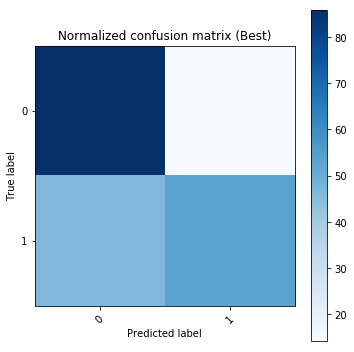


<class 'numpy.ndarray'> (10772,) (4588,)
TRAIN: [    0     1     2 ..., 15087 15088 15089] TEST: [  570   571   572 ..., 15357 15358 15359]
['p002' 'p003' 'p005' 'p006' 'p007' 'p009' 'p012' 'p013' 'p019' 'p020'
 'p021' 'p022' 'p023' 'p024' 'p025' 'p026' 'p027' 'p029' 'p030' 'p032']
['p004' 'p008' 'p011' 'p014' 'p015' 'p016' 'p028' 'p031' 'p033']
0    8552
1    2220
Name: 0, dtype: int64
0    3658
1     930
Name: 0, dtype: int64


Normalizing data!
Grid Search Classifiers!
Best
Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit,GroupShuffleSplit
from scipy import stats

#gss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=0)
gss = GroupShuffleSplit(n_splits=2, test_size=0.3, random_state=0)

for train_index, test_index in gss.split(xData, yDataBin, groups=groups_data):
    print(type(train_index), train_index.shape, test_index.shape)
    print("TRAIN:", train_index, "TEST:", test_index)
    print(np.unique(groups_data.iloc[train_index]))
    print(np.unique(groups_data.iloc[test_index]))
    dt = pd.DataFrame(yDataBin[train_index])
    print(dt[0].value_counts())
    dte = pd.DataFrame(yDataBin[test_index])
    print(dte[0].value_counts())
    print()
    print()
    
    search(xData.iloc[train_index,:], xData.iloc[test_index,:], 
           yDataBin[train_index], yDataBin[test_index], 
           groups_data.iloc[train_index])
    

In [ ]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(xData, yDataBin, test_size=0.3, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape,
      type(X_train.shape), type(X_test.shape), type(y_train.shape), type(y_test.shape))

In [ ]:
search(X_train, X_test, y_train, y_test)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(nds.iloc[:,2:])
nnds = pca.transform(nds.iloc[:,2:])